In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

import searchnets
from searchnets.utils.dataset import VisSearchDataset

In [2]:
model = searchnets.nets.alexnet.build(pretrained=True)

In [3]:
activations = {}

def hook_fn(module, inp, out):
    activations[module] = out

def register_forward_hooks(net):
    modules = [module for module in net.modules() if type(module) != nn.Sequential and type(module) != type(net)]
    for module in modules:
        module.register_forward_hook(hook_fn)

In [4]:
register_forward_hooks(model)

In [5]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

In [6]:
normalize = transforms.Normalize(mean=MEAN,
                                 std=STD)

In [7]:
batch_size = 64
num_workers = 32

In [8]:
csv_file = Path('~/Documents/repos/L2M/visual-search-nets/data/visual_search_stimuli/alexnet_RVvGV/alexnet_RVvGV_finetune_split.csv')
csv_file = csv_file.expanduser()

In [9]:
trainset = VisSearchDataset(csv_file=csv_file,
                        split='test',
                        transform=transforms.Compose(
                            [transforms.ToTensor(), normalize]
                        ))

train_loader = DataLoader(trainset, batch_size=batch_size,
                          shuffle=True, num_workers=num_workers,
                          pin_memory=True)

In [14]:
# if torch.cuda.is_available():
#     device = torch.device('cuda')
#else:
device = torch.device('cpu')

In [15]:
model.to(device);

In [16]:
mn_act_vis_search = {k: [] for k in activations.keys()}
std_act_vis_search = {k: [] for k in activations.keys()}

In [17]:
total = int(np.ceil(len(trainset) / batch_size))
pbar = tqdm(train_loader)
for i, (batch_x, batch_y) in enumerate(pbar):
    pbar.set_description(f'batch {i} of {total}')
    batch_x, batch_y = batch_x.to(device), batch_y.to(device)
    output = model(batch_x)
    for k, v in activations.items():
        v_arr = v.detach().cpu().numpy()
        mn_act_vis_search[k].append(v_arr.mean())
        std_act_vis_search[k].append(v_arr.std())


batch 12 of 13: 100%|██████████| 13/13 [00:08<00:00,  2.17it/s]

In [18]:
imagenet_root = Path('~/Documents/data/imagenet')
imagenet_root = imagenet_root.expanduser()
imagenet_data = torchvision.datasets.ImageNet(imagenet_root,
                                              transform=transforms.Compose([
                                                  transforms.RandomResizedCrop(224),
                                                  transforms.RandomHorizontalFlip(),
                                                  transforms.ToTensor(),
                                                  normalize,
                                              ]))
imagenet_loader = torch.utils.data.DataLoader(imagenet_data,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=num_workers)

In [19]:
mn_act_imagenet = {k: [] for k in activations.keys()}
std_act_imagenet = {k: [] for k in activations.keys()}

In [20]:
total = int(np.ceil(len(imagenet_data) / batch_size))
pbar = tqdm(imagenet_loader)
for i, (batch_x, batch_y) in enumerate(pbar):
    pbar.set_description(f'batch {i} of {total}')
    batch_x, batch_y = batch_x.to(device), batch_y.to(device)
    output = model(batch_x)
    for k, v in activations.items():
        v_arr = v.detach().cpu().numpy()
        mn_act_imagenet[k].append(v_arr.mean())
        std_act_imagenet[k].append(v_arr.std())
    if i > 13:
        break


batch 14 of 20019:   0%|          | 14/20019 [00:11<3:07:31,  1.78it/s]

In [21]:
for k, v in activations.items():
    print("mean: ", v.detach().cpu().numpy().mean(), "std: ", v.detach().cpu().numpy().std())

mean:  0.4535742 std:  1.1610869
mean:  0.4535742 std:  1.1610869
mean:  1.3243948 std:  1.9384093
mean:  0.5530129 std:  1.7541001
mean:  0.5530129 std:  1.7541001
mean:  1.694547 std:  3.0790467
mean:  0.57156616 std:  1.8662821
mean:  0.57156616 std:  1.8662821
mean:  0.5149143 std:  1.5599234
mean:  0.5149143 std:  1.5599234
mean:  0.23682699 std:  0.9562867
mean:  0.23682699 std:  0.9562867
mean:  0.73311025 std:  1.679327
mean:  0.73311025 std:  1.679327
mean:  0.7300646 std:  2.4831705
mean:  0.8731848 std:  1.9375826
mean:  0.8731848 std:  1.9375826
mean:  0.8741058 std:  2.880136
mean:  0.31321308 std:  1.1925573
mean:  0.31321308 std:  1.1925573
mean:  6.7861554e-05 std:  3.6690922


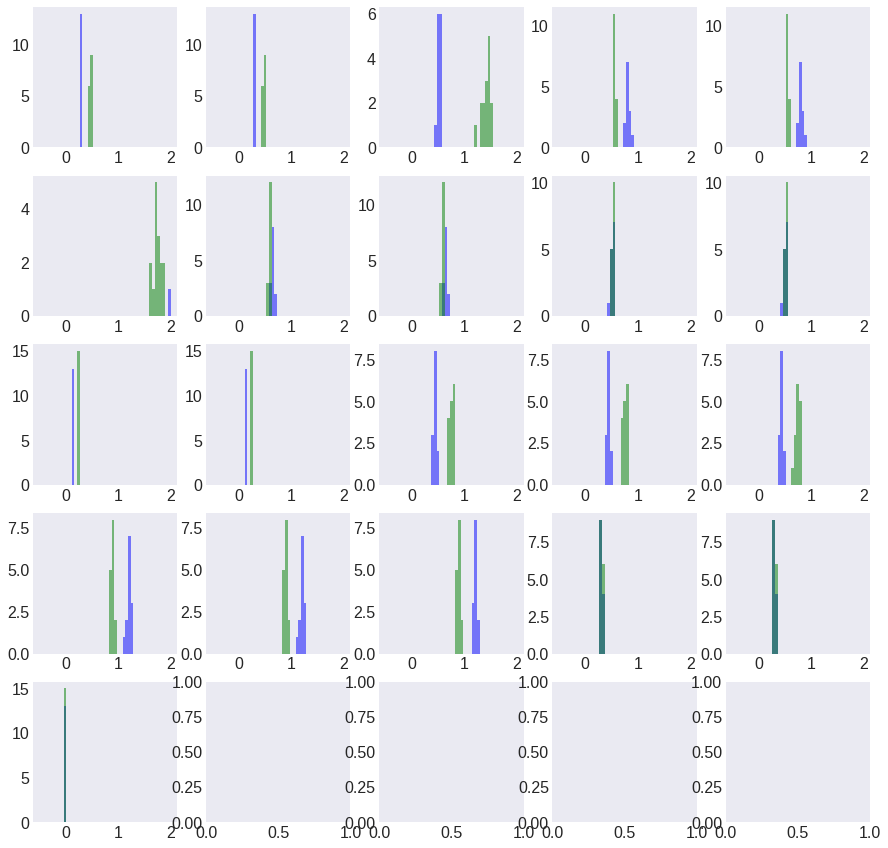

In [22]:
bins = np.linspace(-0.5, 2, 50)

fig, ax = plt.subplots(5, 5)
fig.set_size_inches(15, 15)
ax = ax.ravel()
for i, (k, v) in enumerate(mn_act_vis_search.items()):
    ax[i].hist(v, bins, alpha=0.5, color='blue', label='vis search')
for i, (k, v) in enumerate(mn_act_imagenet.items()):
    ax[i].hist(v, bins, alpha=0.5, color='green', label='imagenet')

plt.savefig('mean_activations_hist.png')

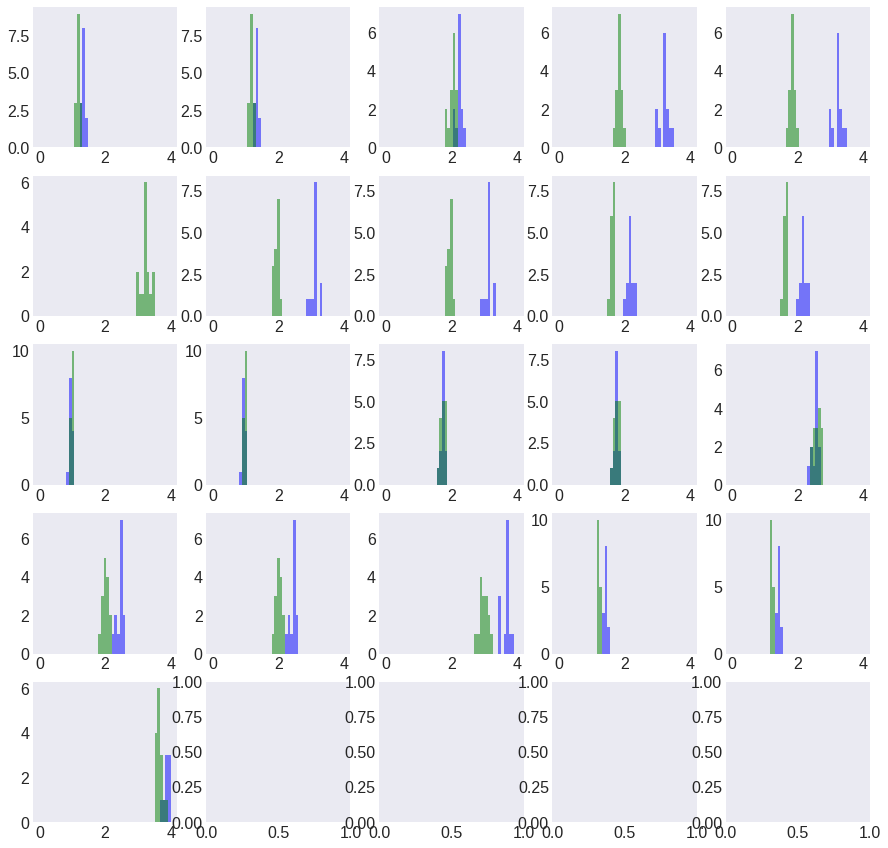

In [24]:
bins = np.linspace(0, 4, 50)

fig, ax = plt.subplots(5, 5)
fig.set_size_inches(15, 15)
ax = ax.ravel()
for i, (k, v) in enumerate(std_act_vis_search.items()):
    ax[i].hist(v, bins, alpha=0.5, color='blue', label='vis search')
for i, (k, v) in enumerate(std_act_imagenet.items()):
    ax[i].hist(v, bins, alpha=0.5, color='green', label='imagenet')

plt.savefig('std_activations_hist.png')